# Checking for the presence of physical GPUs 

In [1]:
import tensorflow as tf

# List all available physical GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # List logical GPUs after setting memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')

        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Importing necessary modules


In [97]:
# Importing the needed libraries
import getpass
import glob
import keras
import os
import pickle
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio

import tensorflow as tf
import segmentation_models as sm

from pathlib import Path

from random import choice
from segmentation_models import Unet
from scipy.ndimage import gaussian_filter

import torch


from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.models import load_model
from keras.optimizers import *
from keras.preprocessing import image

from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

from keras.callbacks import ModelCheckpoint

from tensorflow.python.keras.backend import resize_images
import tensorflow_addons as tfa

import cv2
import gc

from scipy import ndimage

from typing import List, Any, Callable, Tuple

In [ ]:
seed = 2023

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=2023)

# Dataset Loading

In [4]:

new_dir = "D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test"


train_source_items = f"{new_dir}/train"
train_label_items = f"{new_dir}/labels/train"

#image snapshot dimensions
IMG_WIDTH = 256 
IMG_HEIGHT = 256 
IMG_CHANNELS = 4 #we have the rgba bands

In [5]:
# You need to change the way you access the subdirectories
next(os.walk(train_source_items))[1][0] # This will give you the first subdirectory name, e.g. 2021_01
#next(os.walk(train_label_items))[2][0] # This will give you the first label file name, e.g. 2021_01_0001.tif

'2021_03'

We have two sets of data: the train and Private test dataset, each having a list of file ids belonging to them. For model development purposes, we will use the training set(train_tiles) and use the test set for model prediction/evaluation.

In [6]:
new_dir = "D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test"

# You need to change the paths to the train source and label items
train_source_items = f"{new_dir}/train"
train_label_items = f"{new_dir}/labels/train"

# You need to change the way you access the subdirectories and files
subdir = random.choice(next(os.walk(train_source_items))[1]) # This will give you a random subdirectory name, e.g. 2021_01
label_id = random.choice(next(os.walk(f"{train_source_items}/{subdir}"))[2]).split('_')[0] # This will give you a random label id, e.g. 0001
print(label_id)
bd1 = rio.open(f"{train_source_items}/{subdir}/{label_id}_B01.tif")
bd1_array = bd1.read(1)
bd2 = rio.open(f"{train_source_items}/{subdir}/{label_id}_B02.tif")
bd2_array = bd2.read(1)
bd3 = rio.open(f"{train_source_items}/{subdir}/{label_id}_B03.tif")
bd3_array = bd3.read(1)
bd4 = rio.open(f"{train_source_items}/{subdir}/{label_id}_B04.tif")
bd4_array = bd4.read(1)

field = np.dstack((bd4_array, bd3_array, bd2_array, bd1_array))

field = np.sqrt(field)

#data standardization
for c in range(field.shape[2]):
    mean = field[:, :, c].mean()
    std = field[:, :, c].std()
    field[:, :, c] = (field[:, :, c] - mean) / std


mask  = rio.open(Path.cwd() / f"{train_label_items}/{label_id}.tif").read(1)
mask[0]

whx


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

# Data Augmentation Pipeline

In [7]:
#https://github.com/radix-ai/agoro-field-boundary-detector/tree/master/src/agoro_field_boundary_detector
def t_linear(
    field: np.ndarray,
    mask: np.ndarray,
    _: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply a linear (i.e. no) transformation and save."""
    return field, mask

def t_quartile(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Divide the information into four quarters."""
    assert idx in range(0, 3 + 1)
    x, y = [(0, 0), (0, 1), (1, 0), (1, 1)][idx]
    width, height = mask.shape  # 2d array

    # Slice and recover shape
    field_slice = field[
        (width // 2) * x : (width // 2) * (x + 1), (height // 2) * y : (height // 2) * (y + 1)
    ]
    field_slice = field_slice.repeat(2, axis=0).repeat(2, axis=1)
    mask_slice = mask[
        (width // 2) * x : (width // 2) * (x + 1), (height // 2) * y : (height // 2) * (y + 1)
    ]
    mask_slice = mask_slice.repeat(2, axis=0).repeat(2, axis=1)

    # Normalise masking values
    values = sorted(set(np.unique(mask_slice)) - {0})
    for idx, v in enumerate(values):
        mask_slice[mask_slice == v] = idx + 1
    return field_slice, mask_slice
    
def t_rotation(
    field: np.ndarray,
    mask: np.ndarray,
    rot: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data."""
    assert rot in range(0, 3 + 1)
    for _ in range(rot):
        field = np.rot90(field)
        mask = np.rot90(mask)
    return field, mask

def t_flip(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Flip the data."""
    assert idx in range(0, 2 + 1)
    if idx == 0:  # Diagonal
        field = np.rot90(np.fliplr(field))
        mask = np.rot90(np.fliplr(mask))
    if idx == 1:  # Horizontal
        field = np.flip(field, axis=0)
        mask = np.flip(mask, axis=0)
    if idx == 2:  # Vertical
        field = np.flip(field, axis=1)
        mask = np.flip(mask, axis=1)
    return field, mask

def t_blur(
    field: np.ndarray,
    mask: np.ndarray,
    sigma: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Blur the image by applying a Gaussian filter."""
    assert 0 <= sigma <= 10
    sigma_f = 1.0 + (sigma / 10)
    field = np.copy(field)
    for i in range(3):
        field[:, :, i] = gaussian_filter(field[:, :, i], sigma=sigma_f)
    return field, mask

In [8]:
def show_image(field:np.ndarray, mask:np.ndarray): 
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field[:,:,0:3])  # rgb band
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()

# Plotting A sample field and its mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


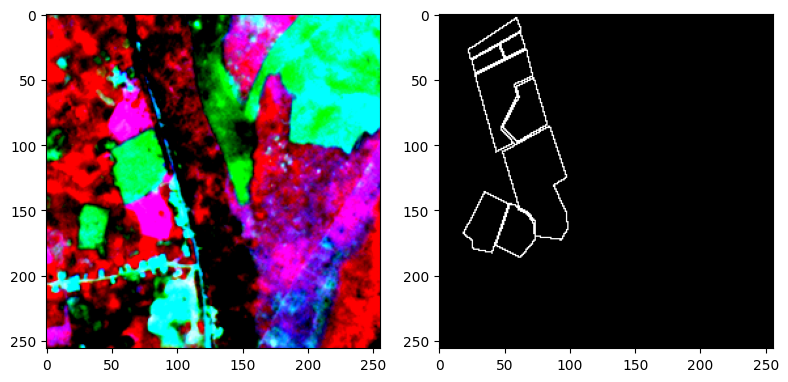

In [9]:
show_image(field,mask)

# Demonstrating effect of applying augmentation - Flipping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


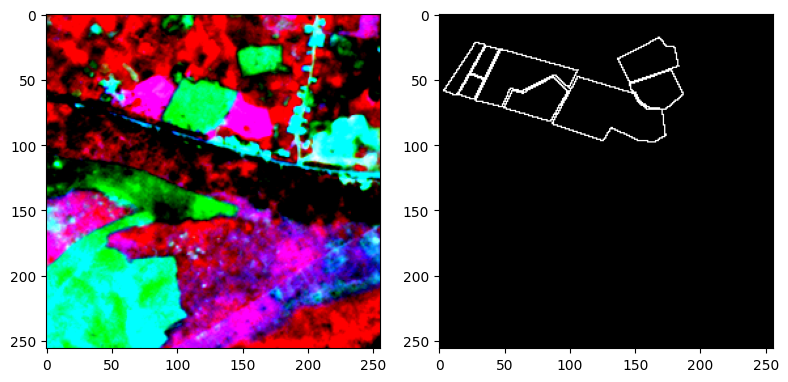

In [10]:
f,m = t_flip(field, mask, idx=0) #flipping
show_image(f,m)

# Demonstrating effect of applying augmentation - Blur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


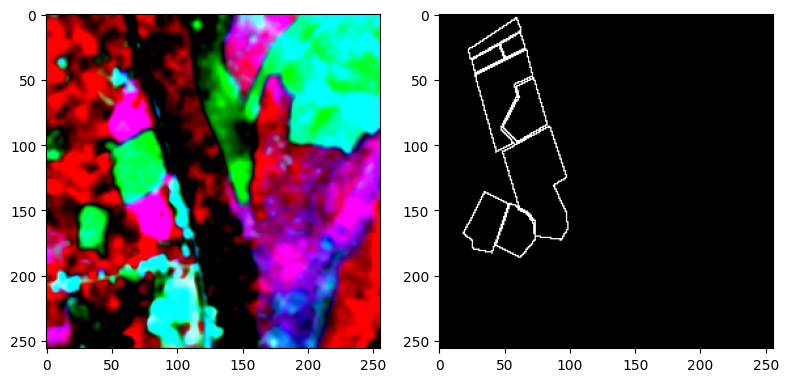

In [11]:
f,m = t_blur(field, mask, sigma=5) #blur
show_image(f,m)

In [12]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    prefix: str = "",
) -> None:
    """
    Generate data augmentations of the provided field and corresponding mask which includes:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param prefix: Field-specific prefix used when writing the augmentation results
    """
    # Generate transformations
    f, m = [0,1,2,3, 4], [0,1,2,3, 4] #dummy data. will be replaced
    f[0],m[0] = t_linear(field, mask) #no augmentation
    f[1],m[1] = t_rotation(field, mask, rot=1) #rotation
    f[2],m[2] = t_flip(field, mask, idx=0) #flipping
    f[3],m[3] = t_blur(field, mask, sigma=5) #blur
    f[4],m[4] = t_quartile(field, mask, idx=1) #quartile    
    
    for i in range(len(f)):        
    

        with open(write_folder +'/'+ f"fields/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(f[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(write_folder +'/'+ f"masks/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(m[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
def main(
    field: List[np.ndarray],
    mask: List[np.ndarray],
    prefix: List[str],
    write_folder: Path,
) -> None:
    """
    Generate and save data augmentations for all the fields and corresponding masks with the following:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Gamma filter (brightness)
    :param fields: Fields to augment
    :param masks: Corresponding masks to augment
    :param prefixes: Field-specific prefixes corresponding each field
    :param write_folder: Path to write the results (augmentations) to
    """
    generate(
        field=field,
        mask=mask,
        prefix=prefix,
        write_folder=write_folder,
    )

In [98]:
train_tiles = [f"{subdir}/{label_id.split('_')[0]}" for subdir in next(os.walk(train_source_items))[1] for label_id in next(os.walk(f"{train_source_items}/{subdir}"))[2]]
# Print the number of total training tiles
print(f"Number of total training tiles: {len(train_tiles)}")


Number of total training tiles: 1224


# Applying augmentation effects to training set and saving them

In [15]:
#apply augmentation effects to training set
# Get all the label ids from the subdirectories
train_tiles = [f"{subdir}/{label_id.split('_')[0]}" for subdir in next(os.walk(train_source_items))[1] for label_id in next(os.walk(f"{train_source_items}/{subdir}"))[2]]
for tile in train_tiles:
    # Get the subdirectory and label id from the tile
    subdir, label_id = tile.split('/')
    # Load the image and mask files using the subdirectory and label id
    bd1 = rio.open(f"{train_source_items}/{subdir}/{label_id}_B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"{train_source_items}/{subdir}/{label_id}_B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"{train_source_items}/{subdir}/{label_id}_B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"{train_source_items}/{subdir}/{label_id}_B04.tif")
    bd4_array = bd4.read(1)

    field = np.dstack((bd4_array, bd3_array, bd2_array, bd1_array))

    field = np.sqrt(field)

    #data standardization
    for c in range(field.shape[2]):
        mean = field[:, :, c].mean()
        std = field[:, :, c].std()
        field[:, :, c] = (field[:, :, c] - mean) / std


    mask  = rio.open(Path.cwd() / f"{train_label_items}/{label_id}.tif").read(1) 

    #create a folder for the augmented images using the subdirectory
    # if not os.path.isdir(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}"):
    #     os.makedirs(f":/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}")
    #create a folder for the augmented images using the subdirectory
    if not os.path.isdir(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}"):
        os.makedirs(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}")
    if not os.path.isdir(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}/fields"):
        os.makedirs(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}/fields")
    if not os.path.isdir(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}/masks"):
        os.makedirs(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}/masks")

    main( #applying augmentation effects
        field  = field,
        mask   = mask,
        prefix = label_id,
        write_folder = f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train_data/{subdir}",
    ) 



In [18]:

train_data = f"{new_dir}/train_data"

# Get all the subdirectories from the train data folder
subdirs = next(os.walk(train_data))[1] #Get all subdirectories, e.g. 2021_01, 2021_02, etc.

# Initialize an empty list to store all the augmented tile ids
augmented_files = []

# Loop through each subdirectory and append the files to the list
for subdir in subdirs:
    augmented_files.extend(next(os.walk(f"{train_data}/{subdir}/fields"))[2])

# Convert the list to a numpy array
augmented_files = np.array(augmented_files)

# Initialize empty arrays for X and y
X = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(subdirs)), dtype=np.float32) #time-series image
y = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8) #mask for each scene

# Loop through each file and load the corresponding field and mask
i = 0
for file in augmented_files:
    idx = 0
    augmented_id = file.split('.pkl')[0] #id without .pkl extension
    temporal_fields = []
    for subdir in subdirs:
        with open(f"{train_data}/{subdir}/fields/{augmented_id}.pkl", 'rb') as field:
            field = pickle.load(field) 
        X[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx += IMG_CHANNELS
    with open(f"{train_data}/{subdir}/masks/{augmented_id}.pkl", 'rb') as mask:
        mask = pickle.load(mask)
    y[i] = mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    i+=1


In [20]:
len(augmented_files)

1530

# A random image from augmented Files!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


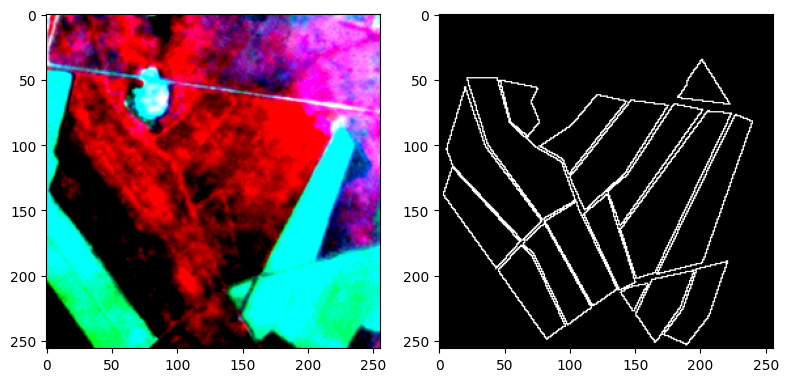

In [21]:
random.randint(0, len(augmented_files)) #sanity check
random_image = random.randint(0, len(augmented_files)-1)
show_image(X[random_image][:,:,0:3], y[random_image].reshape(IMG_WIDTH, IMG_HEIGHT))

# Scheduler

The scheduler is a custom callback for Keras that implements a learning rate policy called **stochastic gradient descent with warm restarts (SGDR)**. This policy adjusts the learning rate according to a cosine function with periodic restarts to the maximum value. 


In [22]:
class SGDRScheduler(tf.keras.callbacks.Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

# Training Hyperparameters

In [23]:
BACKBONE = 'efficientnetb7'


num_channels = 24
input_shape = (256,256,num_channels)


BATCH_SIZE = 4 

LR = 1e-4

N_EPOCHS = 100

MIN_LR = 1e-6

MAX_LR = 1e-2

MULTI_FACTOR = 1.5

DECAY_RATE = 0.85

WEIGHT_DECAY = 1e-5

# Evaluation Metrics

In [24]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall_   = recall(y_true, y_pred)
    return 2*((precision*recall_)/(precision+recall_+K.epsilon()))

# Loss Function

We have tried :
-  Binary Crossentropy
-  Focal loss
-  Dice loss
-  Combo loss —  dice loss + focal
-  Combo loss — dice + binary crossentropy ( I tried different weighting configs before landing on 0.9*dice + 0.1*bce)

  **Finally choose dice + binary crossentropy based on the performance**

In [25]:
# Combo Loss - Dice + Binary crossentropy

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def binary_crossentropy(y, p):
    return K.mean(K.binary_crossentropy(y, p))


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def dice_coef_loss_bce(y_true, y_pred, dice=0.5, bce=0.5):
    return binary_crossentropy(y_true, y_pred) * bce + dice_coef_loss(y_true, y_pred) * dice

def bce_dice_loss(y, p):
    return dice_coef_loss_bce(y, p, dice=0.9, bce=0.1)

# Model Building

I have used the **U-Net architecture with EfficientNetB7** as the backbone. The backbone is the part of the model that extracts features from the input images. EfficientNetB7 is a state-of-the-art backbone that has high accuracy and efficiency on image classification tasks. The reason for choosing this backbone is that it can provide rich and diverse features for the segmentation task, which is the goal of the U-Net model. The model also adds a convolutional layer at the beginning to convert the input images from 24 channels to 3 channels, which is required by the EfficientNetB7 backbone. The model is trained with a cosine annealing learning rate scheduler with periodic restarts, which can improve the convergence and performance of the model.


*Other models that I have tried*:

- Different pretrained model backbones — Efficient net variants(B1-B7), Resnet34, Resnet50, Seresnet34, VGG16 and VGG19-bn.
- Residual Unet
- Channel Attention Based U net

But finally landed on EfficientNetB7 

In [26]:
sm.set_framework('tf.keras')
sm.framework()

def get_model():
    model = None 
    model_unet = Unet(BACKBONE, encoder_weights='imagenet')
    new_model = keras.models.Sequential()
    new_model.add(Conv2D(3, (1,1), padding='same', activation='relu', input_shape=input_shape))
    new_model.add(model_unet)
    model = new_model 

    return model

In [27]:
input_shape

(256, 256, 24)

In [29]:
# reference : https://www.kaggle.com/code/giselama/5-1-multilabel-semantic-segmentation

def stratified_split(x, y, val_size = 0.2, kFold=5):
    ind = np.arange(len(y))
    np.random.shuffle(ind)
    coverage = []
    for i in range(0, len(y)):
        coverage.append(np.sum(y[ind[i]]))

    hist, bin_edges = np.histogram(coverage)
    bin_edges[len(bin_edges)-1] = bin_edges[len(bin_edges)-1] + 1
    cindex = np.digitize(coverage,bin_edges)

    val_size = val_size
    for ii in range(kFold): #5-fold learning
        k = ii
        train_idxs = []
        val_idxs = []
        for i in range(0,10):
            index_temp = ind[cindex==i+1]
            list_temp = index_temp.T.tolist()
            val_samples = round(len(index_temp)*val_size)
            if (k == 0):
                val_idxs = val_idxs + list_temp[:val_samples]
                train_idxs = train_idxs + list_temp[val_samples:]
            elif (k == 4):
                val_idxs = val_idxs + list_temp[4*val_samples:]
                train_idxs = train_idxs + list_temp[:4*val_samples]
            else:
                val_idxs = val_idxs + list_temp[k*val_samples:(k+1)*val_samples]
                train_idxs = train_idxs + list_temp[:k*val_samples] + list_temp[(k+1)*val_samples:]

        val_idxs = ind[val_idxs]
        train_idxs = ind[train_idxs]

    return x[train_idxs],y[train_idxs],x[val_idxs],y[val_idxs]

In [30]:
X.shape

(1530, 256, 256, 24)

# Creating Train and Validation splits

In [31]:
X_train, y_train,X_valid, y_valid  = stratified_split(X, y, val_size = 0.2, kFold=5)

In [43]:
X_train.shape, X_valid.shape

((1224, 256, 256, 24), (306, 256, 256, 24))

In [34]:
# Load all train tiles
# Get all the label ids from the subdirectories
train_tiles = [f"{subdir}/{label_id.split('_')[0]}" for subdir in next(os.walk(train_source_items))[1] for label_id in next(os.walk(f"{train_source_items}/{subdir}"))[2]]
bands_arr = np.zeros((len(train_tiles), IMG_HEIGHT, IMG_WIDTH, 4), dtype = np.float32)

for tid, tile in enumerate(train_tiles):
    # Get the subdirectory and label id from the tile
    subdir, label_id = tile.split('/')
    # Load the image files using the absolute paths
    bd1 = rio.open(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train/{subdir}/{label_id}_B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train/{subdir}/{label_id}_B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train/{subdir}/{label_id}_B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/train/{subdir}/{label_id}_B04.tif")
    bd4_array = bd4.read(1)

    bands_arr[tid] = np.dstack((bd4_array, bd3_array, bd2_array, bd1_array))
    

bands_arr = np.sqrt(bands_arr)

#data standardization
for c in range(bands_arr.shape[-1]):
    mean = bands_arr[:, :, :, c].mean()
    std = bands_arr[:, :, :, c].std()
    bands_arr[:, :, :, c] = (bands_arr[:, :, :, c] - mean) / std



tiles = bands_arr.copy()

del bands_arr
_ = gc.collect()


In [40]:
X_train.shape, y_train.shape

((1224, 256, 256, 24), (1224, 256, 256, 1))

# Training 

**Optimizers**

I have tried these 3 Optimizers:

- Adam
- AdamW
- SGD

But finally landed on AdamW as it offered best results together with stochastic gradient descent scheduler with warm restarts

In [44]:
seed_everything(seed=2023)

#K.clear_session()
N_EPOCHS = 200
y_valid = tf.cast(y_valid, tf.float32)
y_train = tf.cast(y_train, tf.float32)   

mc = ModelCheckpoint(f'D:/New folder/Saved Models/best_model.h5', monitor='val_f1', verbose=0, save_best_only=True,
                                    save_weights_only=True, mode='max')

sched = SGDRScheduler(min_lr= MIN_LR,
                                  max_lr=MAX_LR,
                                  steps_per_epoch=np.ceil(N_EPOCHS/BATCH_SIZE),
                                  lr_decay=DECAY_RATE,
                                  mult_factor=MULTI_FACTOR)

cbs = [sched, mc]


model = get_model()

model.compile(loss= bce_dice_loss,
            #  optimizer=tf.keras.optimizers.AdamW(learning_rate=LR, decay=WEIGHT_DECAY),
               optimizer=tfa.optimizers.AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
              metrics=[f1, recall])
BATCH_SIZE =4
history = model.fit(X_train,y_train,
              validation_data=(X_valid, y_valid),batch_size = BATCH_SIZE,
              steps_per_epoch = len(X_train)//BATCH_SIZE,
              validation_steps = np.ceil(len(X_valid)/BATCH_SIZE), epochs=N_EPOCHS,
              callbacks=cbs)


C:\Users\ruet\AppData\Local\conda\conda\envs\tf-ml\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/200
306/306 [==============================] - 300s 951ms/step - loss: 0.6476 - f1: 0.3272 - recall: 0.4193 - val_loss: 0.6276 - val_f1: 0.3538 - val_recall: 0.5106
Epoch 2/200
306/306 [==============================] - 284s 927ms/step - loss: 0.5833 - f1: 0.3940 - recall: 0.4819 - val_loss: 0.5783 - val_f1: 0.3979 - val_recall: 0.3990
Epoch 3/200
306/306 [==============================] - 281s 917ms/step - loss: 0.5880 - f1: 0.3891 - recall: 0.4770 - val_loss: 0.8724 - val_f1: 0.0541 - val_recall: 0.0333
Epoch 4/200
306/306 [==============================] - 282s 922ms/step - loss: 0.5808 - f1: 0.3967 - recall: 0.4846 - val_loss: 0.5730 - val_f1: 0.4093 - val_recall: 0.5876
Epoch 5/200
306/306 [==============================] - 280s 916ms/step - loss: 0.5234 - f1: 0.4565 - recall: 0.5334 - val_loss: 0.5096 - val_f1: 0.4700 - val_recall: 0.5184
Epoch 6/200
306/306 [==============================] - 277s 907ms/step - loss: 0.5153 - f1: 0.4651 - recall: 0.5408 - val_loss: 0.5553 

In [62]:
model.save('D:/New folder/Saved Models/final.h5')

# Plotting evaluation curves

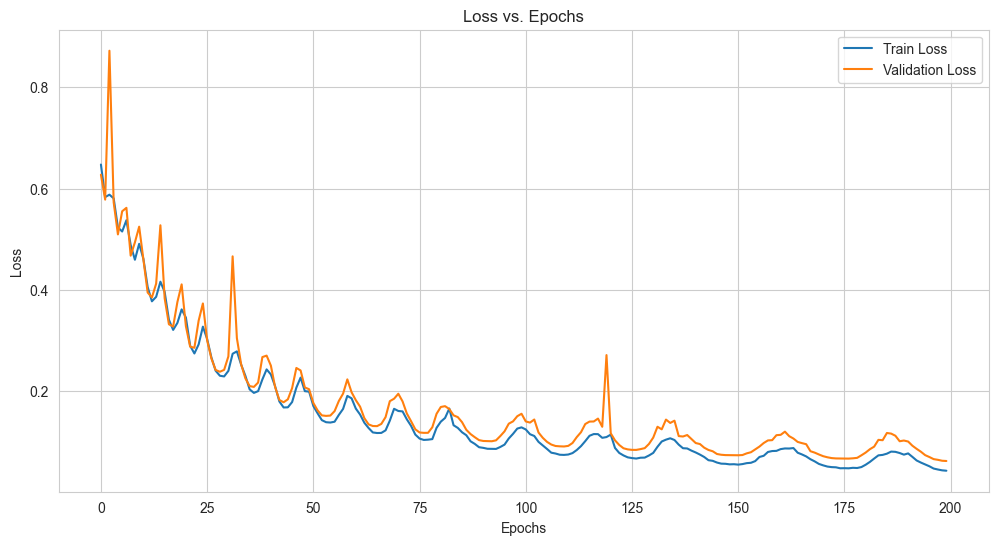

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract loss, F1, and recall values from the training history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
f1_values = history.history['f1']
val_f1_values = history.history['val_f1']
recall_values = history.history['recall']
val_recall_values = history.history['val_recall']

sns.set_style("whitegrid")

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

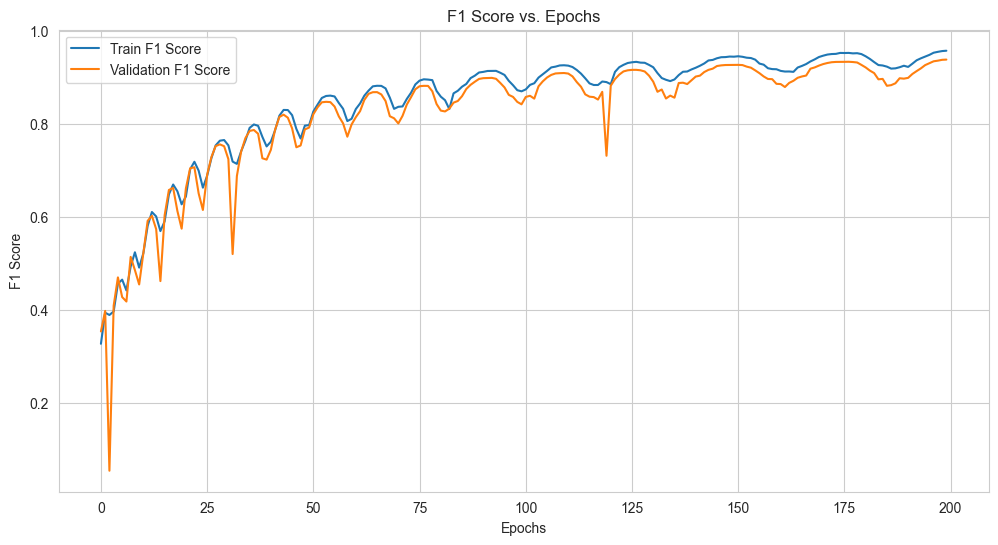

In [59]:
# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(f1_values, label='Train F1 Score')
plt.plot(val_f1_values, label='Validation F1 Score')
plt.title('F1 Score vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

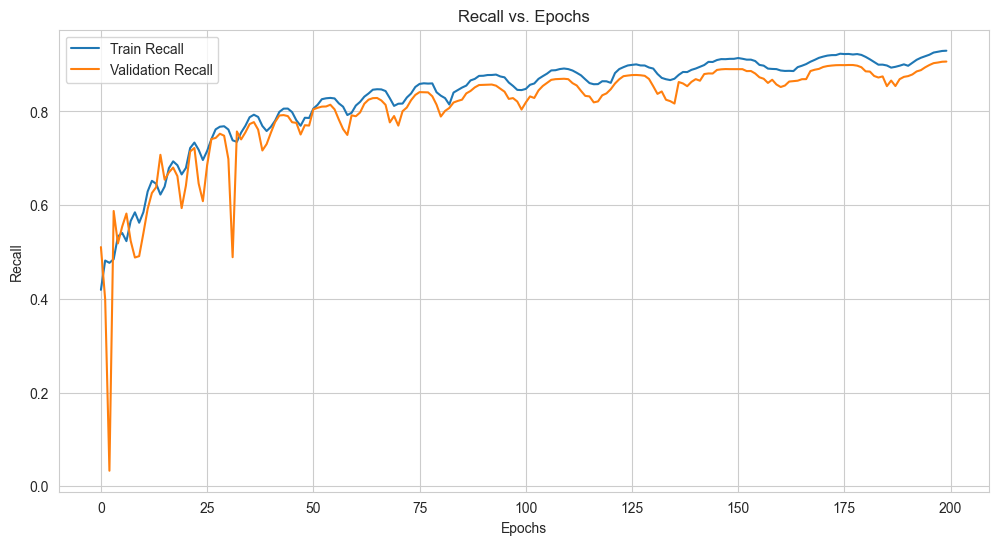

In [60]:
# Plot Recall
plt.figure(figsize=(12, 6))
plt.plot(recall_values, label='Train Recall')
plt.plot(val_recall_values, label='Validation Recall')
plt.title('Recall vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Inference

In [48]:
def normalize(array: np.ndarray) -> np.ndarray:
    """Normalize image to give a meaningful output."""
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [94]:
# You need to specify the path to your train data folder
train_data = f"{new_dir}/train_data"

# Get all the subdirectories from the train data folder
subdirs_1 = next(os.walk(train_data))[1] #Get all subdirectories, e.g. 2021_01, 2021_02, etc.


In [95]:
import os
import glob

# Specify the path to the private test imagery folder
private_test_items = f"{new_dir}/private"

# Initialize a variable to store the total count
total_tif_count = 0

# Use a recursive search to find all .tif files in the directory and its subdirectories
for root, dirs, files in os.walk(private_test_items):
    for file in files:
        if file.endswith(".tif"):
            total_tif_count += 1

# Print the total count of .tif files
print(f"Total .tif files in {private_test_items}: {total_tif_count}")


Total .tif files in D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/private: 72


# Loading test chips to run predictions

In [96]:
IMG_CHANNELS = 4

# Specify the path to the private test imagery folder
private_test_items = f"{new_dir}/private"

# Get all the subdirectories representing years and months
subdirs = next(os.walk(private_test_items))[1]
print(len(subdirs))
# Initialize empty arrays for X_test and test_tile_ids
# Initialize empty arrays for X_test and test_tile_ids
X_test = np.empty((72, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(subdirs_1)), dtype=np.float32)
test_tile_ids = []

i = 0
idx = 0  # Move idx outside the inner loop
for subdir in subdirs:
    test_id_dirs = next(os.walk(f"{private_test_items}/{subdir}"))[1]

    for test_id_dir in test_id_dirs:
        bd1 = rio.open(
            f"{private_test_items}/{subdir}/{test_id_dir}/{test_id_dir}_B01.tif"
        )
        bd1_array = bd1.read(1)
        bd2 = rio.open(
            f"{private_test_items}/{subdir}/{test_id_dir}/{test_id_dir}_B02.tif"
        )
        bd2_array = bd2.read(1)
        bd3 = rio.open(
            f"{private_test_items}/{subdir}/{test_id_dir}/{test_id_dir}_B03.tif"
        )
        bd3_array = bd3.read(1)
        bd4 = rio.open(
            f"{private_test_items}/{subdir}/{test_id_dir}/{test_id_dir}_B04.tif"
        )
        bd4_array = bd4.read(1)

        field = np.dstack((bd4_array, bd3_array, bd2_array, bd1_array))
        field = np.sqrt(field)
        # print(field)
        # data standardization
        for c in range(field.shape[2]):
            mean = field[:, :, c].mean()
            std = field[:, :, c].std()
            field[:, :, c] = (field[:, :, c] - mean) / std
        X_test[idx][:, :, :IMG_CHANNELS] = field
        idx += IMG_CHANNELS  # Increment idx by IMG_CHANNELS for each test_id_dir
        test_tile_ids.append(test_id_dir)
    i += 1  # Increment i by 1 for each subdir


3


**Load best model to run predictions**


In [87]:
# load best model to run predictions
# You need to specify the path to your best model file
best_model_path = f'D:/New folder/Saved Models/final.h5'


# Load your best model
model = keras.models.load_model(
    best_model_path,
    custom_objects={"bce_dice_loss": bce_dice_loss, "f1": f1, "recall": recall},
)

model.load_weights("D:/New folder/Saved Models/best_model.h5")

preds = model.predict(X_test, verbose=1, batch_size=BATCH_SIZE)

18/18 [==============================] - 8s 236ms/step


# Inference mask images from the private test set

In [90]:
# Convert predictions into binary masks
preds = (preds > 0.5).astype(np.uint8)

# Create a folder for inference
os.makedirs(f"{new_dir}/inference", exist_ok=True)

# Loop over the subdirectories and test ids
idx = 0
for subdir in subdirs:
    test_id_dirs = next(os.walk(f"{private_test_items}/{subdir}"))[1]

    for test_id_dir in test_id_dirs:
        # Create a subfolder for each test id
        os.makedirs(f"{new_dir}/inference/{subdir}/{test_id_dir}", exist_ok=True)

        # Open the original image
        bd1 = rio.open(
            f"{private_test_items}/{subdir}/{test_id_dir}/{test_id_dir}_B01.tif"
        )

        # Open a new file for writing the mask image
        with rio.open(
            f"{new_dir}/inference/{subdir}/{test_id_dir}/{test_id_dir}.tif",
            "w",
            **bd1.profile,
        ) as dst:
            # Write the mask image to the file
            dst.write(preds[idx][:, :, 0], 1)

        # Increment idx by IMG_CHANNELS for each test id
        idx += IMG_CHANNELS



# Plotting a Inference Mask

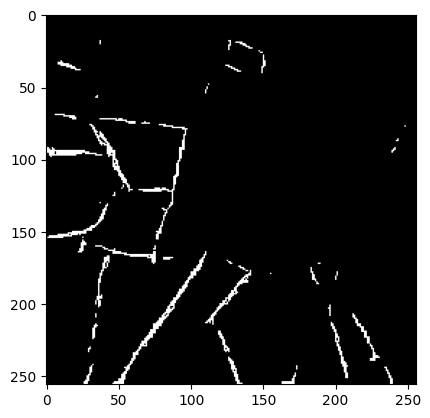

In [92]:
# Import matplotlib
import matplotlib.pyplot as plt

# Open the mask image file
mask = rio.open("D:/New folder/Spacenus_ML_Engineer_Assignment/Field_boundary_detection_test/inference/2021_08/bb/bb.tif")

# Read the mask image as a numpy array
mask_array = mask.read(1)

# Plot the mask image
plt.imshow(mask_array, cmap="gray")
plt.show()
